**Monte Carlo**

Best Strategy Win Rate: 0.364


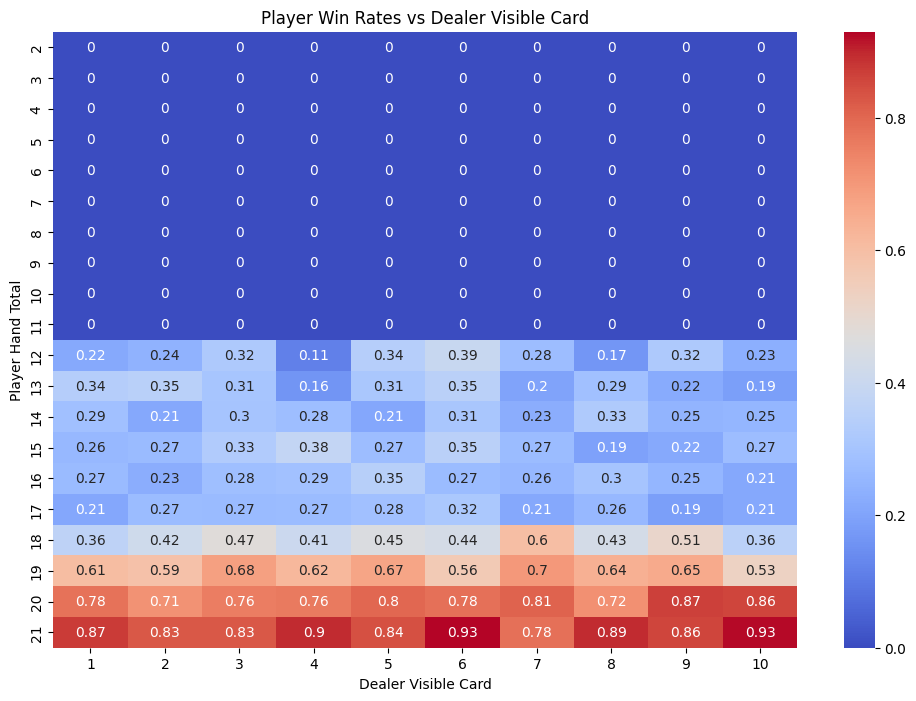

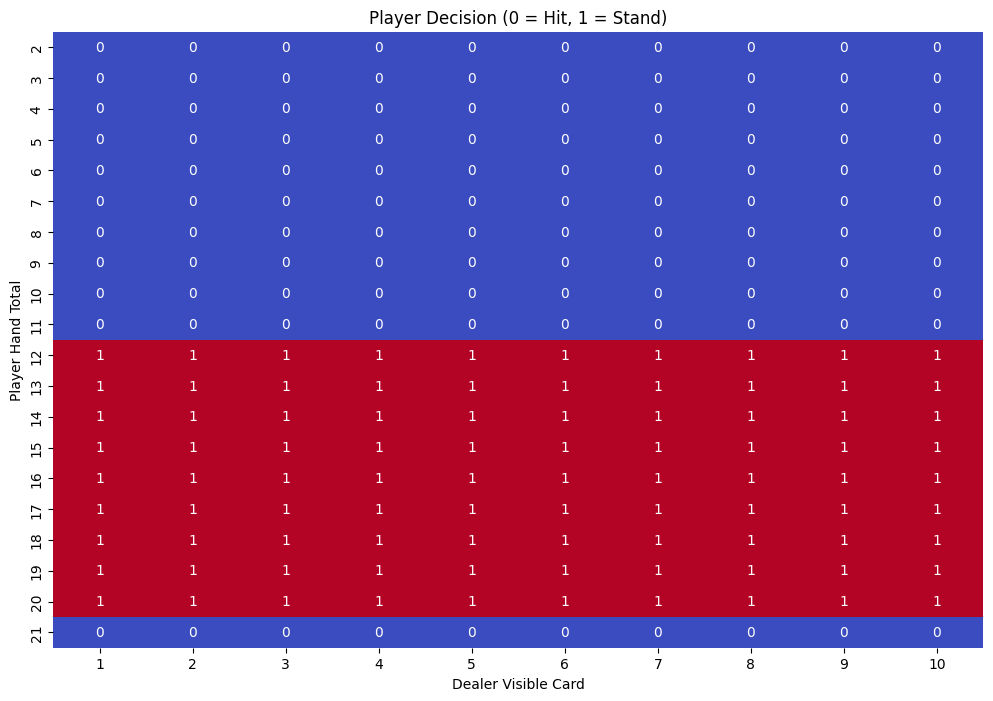

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def simulate_blackjack(strategy, num_games=1000):
    win_count = 0
    push_count = 0
    player_outcomes = defaultdict(int)
    dealer_outcomes = defaultdict(int)
    decisions = defaultdict(lambda: [0, 0])  # [hit_count, stand_count]

    for _ in range(num_games):
        player_hand, dealer_hand = deal_initial_hands()
        player_wins, player_total, dealer_total, decision = play_hand(strategy, player_hand, dealer_hand)

        if player_wins == 1:  # Win
            player_outcomes[(player_total, dealer_hand[0])] += 1
            win_count += 1
        elif player_wins == 0:  # Push
            push_count += 1

        dealer_outcomes[(player_total, dealer_hand[0])] += 1
        decisions[(player_total, dealer_hand[0])][decision] += 1  # 0 for hit, 1 for stand

    win_rate = win_count / num_games
    return win_rate, player_outcomes, dealer_outcomes, decisions

def deal_initial_hands():
    player_hand = [random.randint(1, 10), random.randint(1, 10)]
    dealer_hand = [random.randint(1, 10), random.randint(1, 10)]
    return player_hand, dealer_hand

def play_hand(strategy, player_hand, dealer_hand):
    decision = 0  # 0 for hit, 1 for stand
    while sum(player_hand) < 21:
        if strategy(sum(player_hand), dealer_hand[0]):
            player_hand.append(random.randint(1, 10))
            decision = 0
        else:
            decision = 1
            break

    player_score = sum(player_hand)
    dealer_score = sum(dealer_hand)
    while dealer_score < 17:  # Dealer hits until 17 or higher
        dealer_hand.append(random.randint(1, 10))
        dealer_score = sum(dealer_hand)

    if player_score > 21:  # Player busts
        player_wins = -1
    elif dealer_score > 21:  # Dealer busts
        player_wins = 1
    elif player_score > dealer_score:  # Player wins
        player_wins = 1
    elif player_score < dealer_score:  # Dealer wins
        player_wins = -1
    else:  # Push
        player_wins = 0

    return player_wins, player_score, dealer_score, decision

def random_strategy(player_total, dealer_visible):
    return player_total < random.randint(12, 17)

def monte_carlo_strategy_update(best_strategy, std_dev=2):
    def new_strategy(player_total, dealer_visible):
        if player_total < 21:
            return random.gauss(best_strategy(player_total, dealer_visible), std_dev) < 0.5
        return False
    return new_strategy

def monte_carlo_swarm(num_particles, num_iterations, num_games=1000):
    strategies = [random_strategy for _ in range(num_particles)]
    global_best_strategy = strategies[0]
    global_best_win_rate = simulate_blackjack(global_best_strategy, num_games)[0]

    for _ in range(num_iterations):
        for i in range(num_particles):
            new_strategy = monte_carlo_strategy_update(global_best_strategy)
            strategies[i] = new_strategy

            current_win_rate, _, _, _ = simulate_blackjack(new_strategy, num_games)
            if current_win_rate > global_best_win_rate:
                global_best_strategy = new_strategy
                global_best_win_rate = current_win_rate

    return global_best_strategy, global_best_win_rate

def plot_win_rates(player_outcomes, dealer_outcomes, decisions):
    player_win_rates = {k: player_outcomes[k] / dealer_outcomes[k] if dealer_outcomes[k] > 0 else 0
                        for k in dealer_outcomes.keys()}

    player_totals = list(range(2, 22))
    dealer_visibles = list(range(1, 11))

    win_rate_matrix = np.zeros((len(player_totals), len(dealer_visibles)))
    decision_matrix = np.zeros((len(player_totals), len(dealer_visibles)))

    for player_total in player_totals:
        for dealer_visible in dealer_visibles:
            win_rate_matrix[player_total-2, dealer_visible-1] = player_win_rates.get((player_total, dealer_visible), 0)
            hit_count, stand_count = decisions.get((player_total, dealer_visible), [0, 0])
            if hit_count + stand_count > 0:
                decision_matrix[player_total-2, dealer_visible-1] = 1 if stand_count > hit_count else 0

    plt.figure(figsize=(12, 8))
    sns.heatmap(win_rate_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Win Rates vs Dealer Visible Card')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(decision_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals, cbar=False)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Decision (0 = Hit, 1 = Stand)')
    plt.show()

# Example usage
best_strategy, best_win_rate = monte_carlo_swarm(num_particles=10, num_iterations=10, num_games=1000)
print("Best Strategy Win Rate:", best_win_rate)

_, player_outcomes, dealer_outcomes, decisions = simulate_blackjack(best_strategy, num_games=10000)
plot_win_rates(player_outcomes, dealer_outcomes, decisions)

**Bayesian Probability**

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best Strategy Win Rate: 0.405


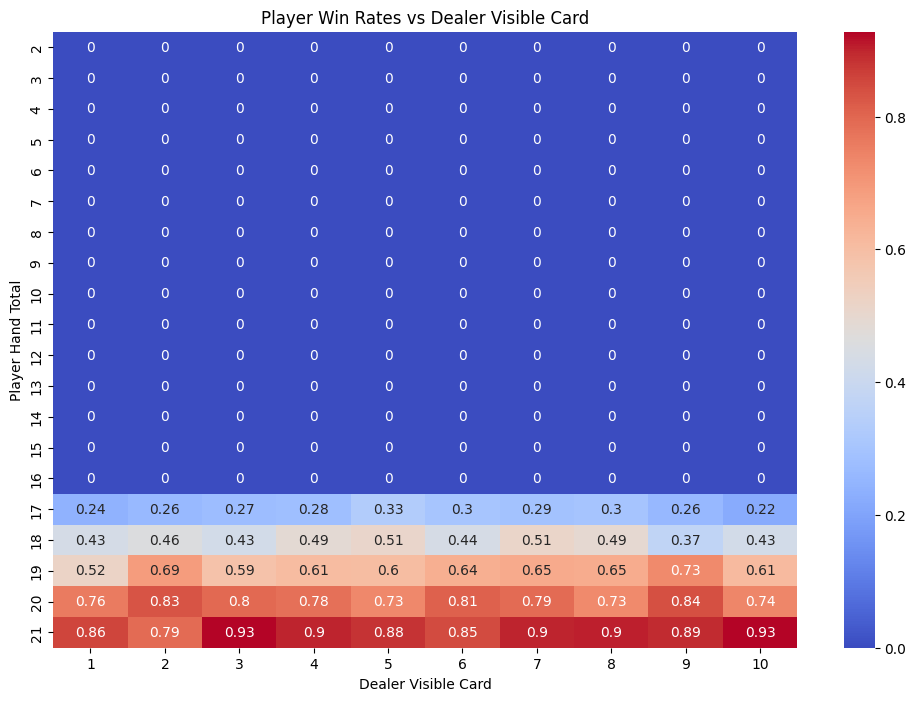

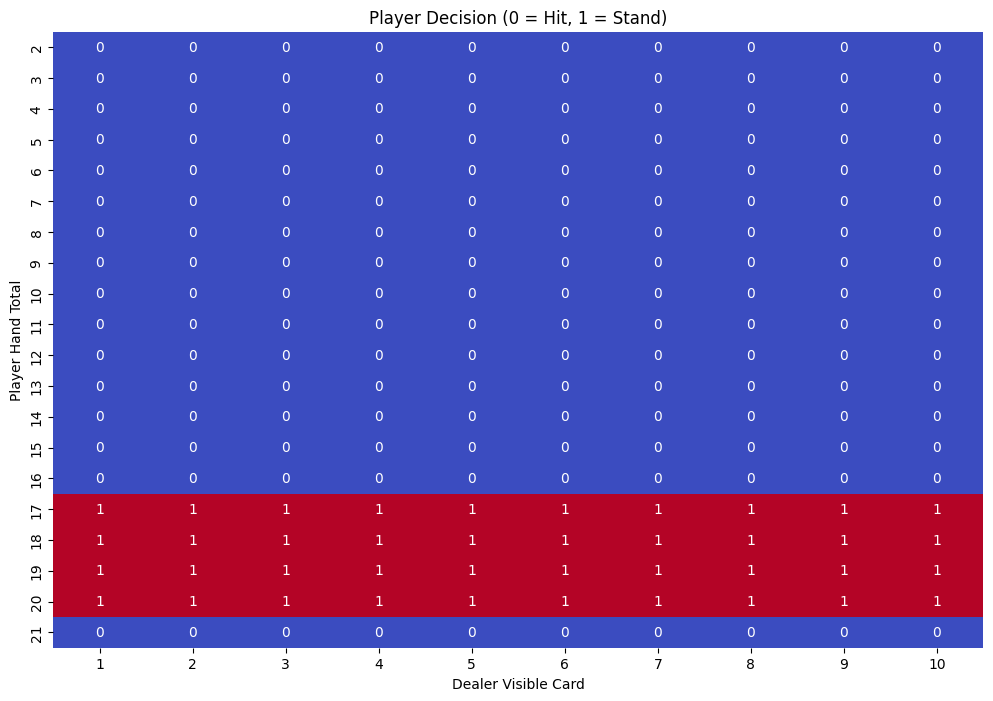

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

def simulate_blackjack(strategy, num_games=1000):
    win_count = 0
    push_count = 0
    player_outcomes = defaultdict(int)
    dealer_outcomes = defaultdict(int)
    decisions = defaultdict(lambda: [0, 0])  # [hit_count, stand_count]

    for _ in range(num_games):
        player_hand, dealer_hand = deal_initial_hands()
        player_wins, player_total, dealer_total, decision = play_hand(strategy, player_hand, dealer_hand)

        if player_wins == 1:  # Win
            player_outcomes[(player_total, dealer_hand[0])] += 1
            win_count += 1
        elif player_wins == 0:  # Push
            push_count += 1

        dealer_outcomes[(player_total, dealer_hand[0])] += 1
        decisions[(player_total, dealer_hand[0])][decision] += 1  # 0 for hit, 1 for stand

    win_rate = win_count / num_games
    return win_rate, player_outcomes, dealer_outcomes, decisions

def deal_initial_hands():
    player_hand = [random.randint(1, 10), random.randint(1, 10)]
    dealer_hand = [random.randint(1, 10), random.randint(1, 10)]
    return player_hand, dealer_hand

def play_hand(strategy, player_hand, dealer_hand):
    decision = 0  # 0 for hit, 1 for stand
    while sum(player_hand) < 21:
        if strategy(sum(player_hand), dealer_hand[0]):
            player_hand.append(random.randint(1, 10))
            decision = 0
        else:
            decision = 1
            break

    player_score = sum(player_hand)
    dealer_score = sum(dealer_hand)
    while dealer_score < 17:  # Dealer hits until 17 or higher
        dealer_hand.append(random.randint(1, 10))
        dealer_score = sum(dealer_hand)

    if player_score > 21:  # Player busts
        player_wins = -1
    elif dealer_score > 21:  # Dealer busts
        player_wins = 1
    elif player_score > dealer_score:  # Player wins
        player_wins = 1
    elif player_score < dealer_score:  # Dealer wins
        player_wins = -1
    else:  # Push
        player_wins = 0

    return player_wins, player_score, dealer_score, decision

def random_strategy(player_total, dealer_visible):
    return player_total < random.randint(12, 17)

def bayesian_strategy_update(best_strategy, gp, bounds, n_samples=10):
    X = np.linspace(bounds[0], bounds[1], n_samples).reshape(-1, 1)
    y_pred, sigma = gp.predict(X, return_std=True)
    best_idx = np.argmax(y_pred + sigma)  # Upper Confidence Bound (UCB)
    new_param = X[best_idx][0]

    def new_strategy(player_total, dealer_visible):
        if player_total < 21:
            return player_total < new_param
        return False
    return new_strategy

def bayesian_swarm(num_particles, num_iterations, num_games=1000):
    strategies = [random_strategy for _ in range(num_particles)]
    global_best_strategy = strategies[0]
    global_best_win_rate = simulate_blackjack(global_best_strategy, num_games)[0]

    kernel = Matern(nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10)

    for iteration in range(num_iterations):
        X = np.array([[i] for i in range(num_particles)])
        y = np.array([simulate_blackjack(s, num_games)[0] for s in strategies])

        gp.fit(X, y)
        mean, std = gp.predict(X, return_std=True)
        acquisition_values = mean + std  # Upper Confidence Bound (UCB)

        best_idx = np.argmax(acquisition_values)
        best_sample = strategies[best_idx]

        strategies = [bayesian_strategy_update(best_sample, gp, bounds=(2, 21)) for _ in range(num_particles)]

        current_win_rate, _, _, _ = simulate_blackjack(best_sample, num_games)
        if current_win_rate > global_best_win_rate:
            global_best_strategy = best_sample
            global_best_win_rate = current_win_rate

    return global_best_strategy, global_best_win_rate

def plot_win_rates(player_outcomes, dealer_outcomes, decisions):
    player_win_rates = {k: player_outcomes[k] / dealer_outcomes[k] if dealer_outcomes[k] > 0 else 0
                        for k in dealer_outcomes.keys()}

    player_totals = list(range(2, 22))
    dealer_visibles = list(range(1, 11))

    win_rate_matrix = np.zeros((len(player_totals), len(dealer_visibles)))
    decision_matrix = np.zeros((len(player_totals), len(dealer_visibles)))

    for player_total in player_totals:
        for dealer_visible in dealer_visibles:
            win_rate_matrix[player_total-2, dealer_visible-1] = player_win_rates.get((player_total, dealer_visible), 0)
            hit_count, stand_count = decisions.get((player_total, dealer_visible), [0, 0])
            if hit_count + stand_count > 0:
                decision_matrix[player_total-2, dealer_visible-1] = 1 if stand_count > hit_count else 0

    plt.figure(figsize=(12, 8))
    sns.heatmap(win_rate_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Win Rates vs Dealer Visible Card')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(decision_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals, cbar=False)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Decision (0 = Hit, 1 = Stand)')
    plt.show()

# Example usage
best_strategy, best_win_rate = bayesian_swarm(num_particles=10, num_iterations=10, num_games=1000)
print("Best Strategy Win Rate:", best_win_rate)

_, player_outcomes, dealer_outcomes, decisions = simulate_blackjack(best_strategy, num_games=10000)
plot_win_rates(player_outcomes, dealer_outcomes, decisions)

**Gaussian Probability**

Best Strategy Win Rate: 0.377


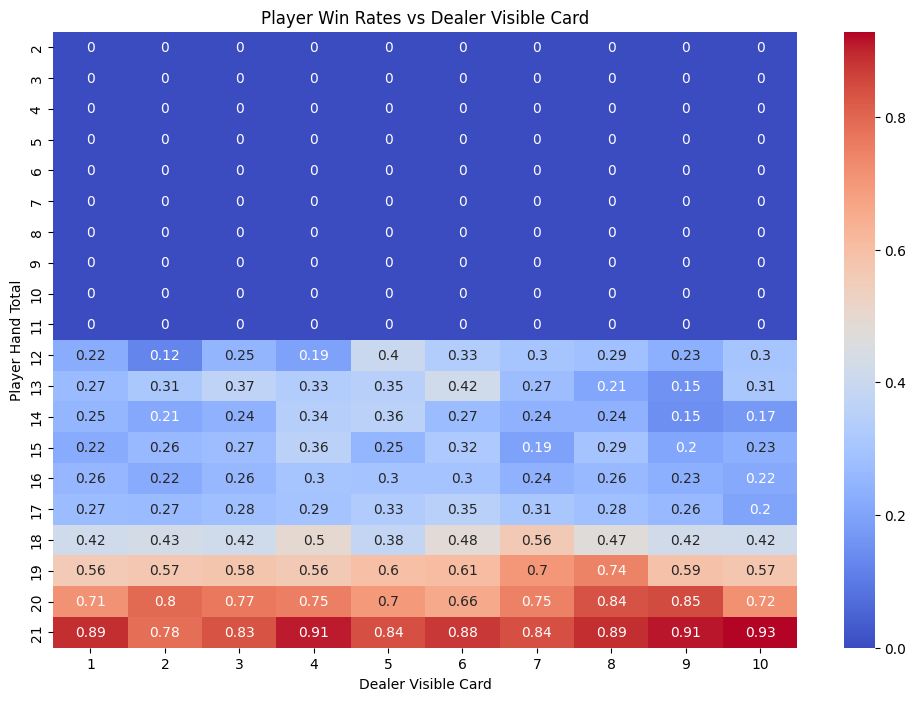

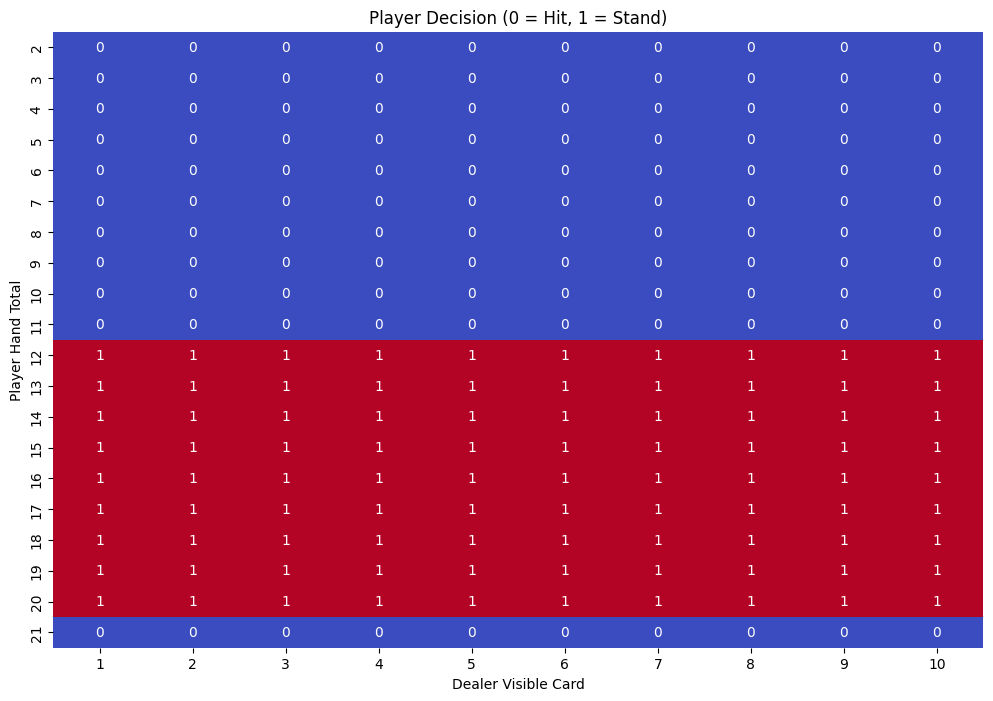

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def simulate_blackjack(strategy, num_games=1000):
    win_count = 0
    push_count = 0
    player_outcomes = defaultdict(int)
    dealer_outcomes = defaultdict(int)
    decisions = defaultdict(lambda: [0, 0])  # [hit_count, stand_count]

    for _ in range(num_games):
        player_hand, dealer_hand = deal_initial_hands()
        player_wins, player_total, dealer_total, decision = play_hand(strategy, player_hand, dealer_hand)

        if player_wins == 1:  # Win
            player_outcomes[(player_total, dealer_hand[0])] += 1
            win_count += 1
        elif player_wins == 0:  # Push
            push_count += 1

        dealer_outcomes[(player_total, dealer_hand[0])] += 1
        decisions[(player_total, dealer_hand[0])][decision] += 1  # 0 for hit, 1 for stand

    win_rate = win_count / num_games
    return win_rate, player_outcomes, dealer_outcomes, decisions

def deal_initial_hands():
    player_hand = [random.randint(1, 10), random.randint(1, 10)]
    dealer_hand = [random.randint(1, 10), random.randint(1, 10)]
    return player_hand, dealer_hand

def play_hand(strategy, player_hand, dealer_hand):
    decision = 0  # 0 for hit, 1 for stand
    while sum(player_hand) < 21:
        if strategy(sum(player_hand), dealer_hand[0]):
            player_hand.append(random.randint(1, 10))
            decision = 0
        else:
            decision = 1
            break

    player_score = sum(player_hand)
    dealer_score = sum(dealer_hand)
    while dealer_score < 17:  # Dealer hits until 17 or higher
        dealer_hand.append(random.randint(1, 10))
        dealer_score = sum(dealer_hand)

    if player_score > 21:  # Player busts
        player_wins = -1
    elif dealer_score > 21:  # Dealer busts
        player_wins = 1
    elif player_score > dealer_score:  # Player wins
        player_wins = 1
    elif player_score < dealer_score:  # Dealer wins
        player_wins = -1
    else:  # Push
        player_wins = 0

    return player_wins, player_score, dealer_score, decision

def random_strategy(player_total, dealer_visible):
    return player_total < random.randint(12, 17)

def gaussian_strategy_update(best_strategy, std_dev=2):
    def new_strategy(player_total, dealer_visible):
        if player_total < 21:
            return random.gauss(best_strategy(player_total, dealer_visible), std_dev) < 0.5
        return False
    return new_strategy

def gaussian_swarm(num_particles, num_iterations, num_games=1000):
    strategies = [random_strategy for _ in range(num_particles)]
    global_best_strategy = strategies[0]
    global_best_win_rate = simulate_blackjack(global_best_strategy, num_games)[0]

    for _ in range(num_iterations):
        for i in range(num_particles):
            new_strategy = gaussian_strategy_update(global_best_strategy)
            strategies[i] = new_strategy

            current_win_rate, _, _, _ = simulate_blackjack(new_strategy, num_games)
            if current_win_rate > global_best_win_rate:
                global_best_strategy = new_strategy
                global_best_win_rate = current_win_rate

    return global_best_strategy, global_best_win_rate

def plot_win_rates(player_outcomes, dealer_outcomes, decisions):
    player_win_rates = {k: player_outcomes[k] / dealer_outcomes[k] if dealer_outcomes[k] > 0 else 0
                        for k in dealer_outcomes.keys()}

    player_totals = list(range(2, 22))
    dealer_visibles = list(range(1, 11))

    win_rate_matrix = np.zeros((len(player_totals), len(dealer_visibles)))
    decision_matrix = np.zeros((len(player_totals), len(dealer_visibles)))

    for player_total in player_totals:
        for dealer_visible in dealer_visibles:
            win_rate_matrix[player_total-2, dealer_visible-1] = player_win_rates.get((player_total, dealer_visible), 0)
            hit_count, stand_count = decisions.get((player_total, dealer_visible), [0, 0])
            if hit_count + stand_count > 0:
                decision_matrix[player_total-2, dealer_visible-1] = 1 if stand_count > hit_count else 0

    plt.figure(figsize=(12, 8))
    sns.heatmap(win_rate_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Win Rates vs Dealer Visible Card')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(decision_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals, cbar=False)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Decision (0 = Hit, 1 = Stand)')
    plt.show()

# Example usage
best_strategy, best_win_rate = gaussian_swarm(num_particles=10, num_iterations=10, num_games=1000)
print("Best Strategy Win Rate:", best_win_rate)

_, player_outcomes, dealer_outcomes, decisions = simulate_blackjack(best_strategy, num_games=10000)
plot_win_rates(player_outcomes, dealer_outcomes, decisions)

**Blackjack Swarm**

Best Strategy Win Rate: 0.41


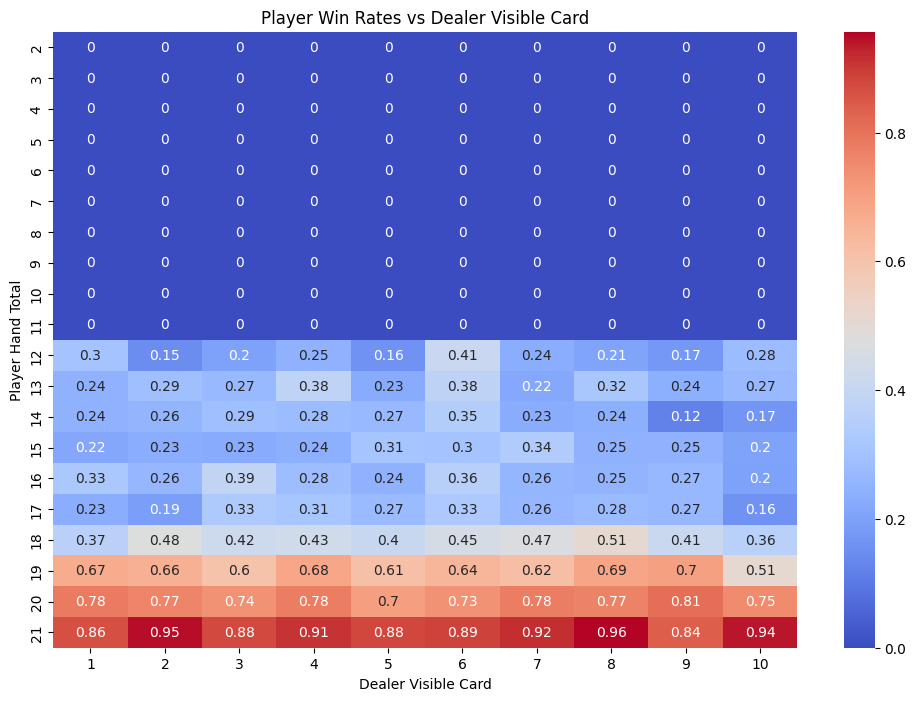

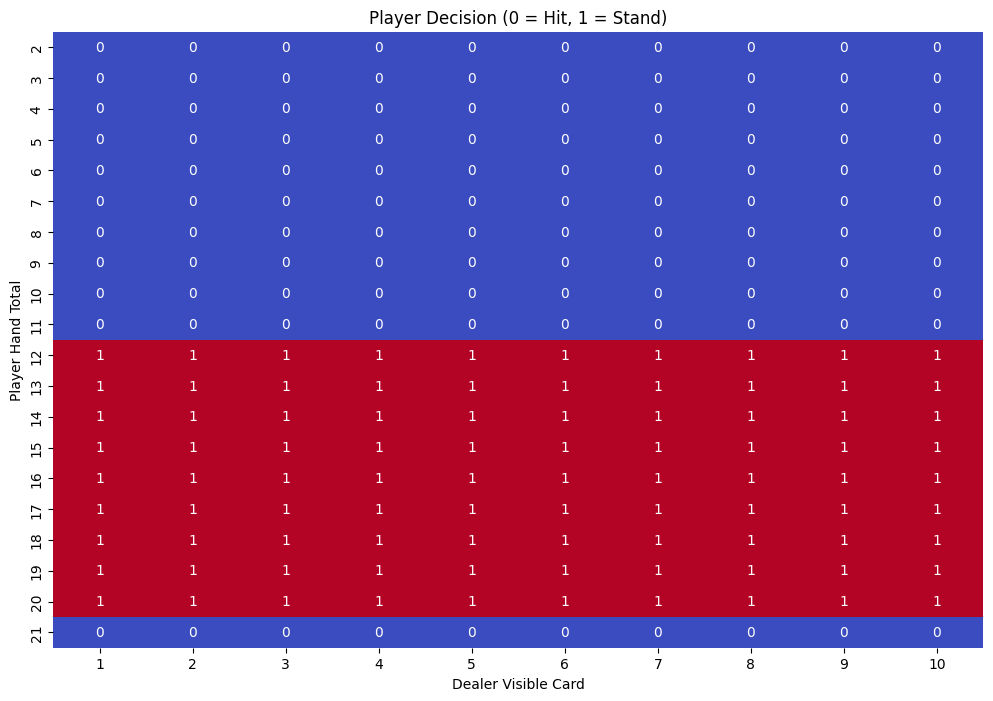

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy

def simulate_blackjack(strategy, num_games=1000):
    win_count = 0
    push_count = 0
    player_outcomes = defaultdict(int)
    dealer_outcomes = defaultdict(int)
    decisions = defaultdict(lambda: [0, 0])  # [hit_count, stand_count]

    for _ in range(num_games):
        player_hand, dealer_hand = deal_initial_hands()
        player_wins, player_total, dealer_total, decision = play_hand(strategy, player_hand, dealer_hand)

        if player_wins == 1:  # Win
            player_outcomes[(player_total, dealer_hand[0])] += 1
            win_count += 1
        elif player_wins == 0:  # Push
            push_count += 1

        dealer_outcomes[(player_total, dealer_hand[0])] += 1
        decisions[(player_total, dealer_hand[0])][decision] += 1  # 0 for hit, 1 for stand

    win_rate = win_count / num_games
    return win_rate, player_outcomes, dealer_outcomes, decisions

def deal_initial_hands():
    player_hand = [random.randint(1, 10), random.randint(1, 10)]
    dealer_hand = [random.randint(1, 10), random.randint(1, 10)]
    return player_hand, dealer_hand

def play_hand(strategy, player_hand, dealer_hand):
    decision = 0  # 0 for hit, 1 for stand
    while sum(player_hand) < 21:
        if strategy(sum(player_hand), dealer_hand[0]):
            player_hand.append(random.randint(1, 10))
            decision = 0
        else:
            decision = 1
            break

    player_score = sum(player_hand)
    dealer_score = sum(dealer_hand)
    while dealer_score < 17:  # Dealer hits until 17 or higher
        dealer_hand.append(random.randint(1, 10))
        dealer_score = sum(dealer_hand)

    if player_score > 21:  # Player busts
        player_wins = -1
    elif dealer_score > 21:  # Dealer busts
        player_wins = 1
    elif player_score > dealer_score:  # Player wins
        player_wins = 1
    elif player_score < dealer_score:  # Dealer wins
        player_wins = -1
    else:  # Push
        player_wins = 0

    return player_wins, player_score, dealer_score, decision

def random_strategy(player_total, dealer_visible):
    return player_total < random.randint(12, 17)

def blackjack_swarm(num_particles, num_iterations, num_games=1000, mutation_rate=0.1):
    # Initialize strategies (particles)
    strategies = [random_strategy for _ in range(num_particles)]
    global_best_strategy = strategies[0]
    global_best_win_rate = simulate_blackjack(global_best_strategy, num_games)[0]

    for iteration in range(num_iterations):
        # Evaluate all strategies
        win_rates = [simulate_blackjack(strategy, num_games)[0] for strategy in strategies]

        # Selection: Keep top 50% strategies
        sorted_indices = np.argsort(win_rates)[::-1]
        top_strategies = [strategies[i] for i in sorted_indices[:num_particles // 2]]

        # Crossover and Mutation to create new strategies
        new_strategies = copy.deepcopy(top_strategies)
        while len(new_strategies) < num_particles:
            parent1, parent2 = random.sample(top_strategies, 2)
            child_strategy = crossover_and_mutate(parent1, parent2, mutation_rate)
            new_strategies.append(child_strategy)

        strategies = new_strategies

        # Update global best strategy
        best_index = np.argmax(win_rates)
        if win_rates[best_index] > global_best_win_rate:
            global_best_strategy = strategies[best_index]
            global_best_win_rate = win_rates[best_index]

    return global_best_strategy, global_best_win_rate

def crossover_and_mutate(parent1, parent2, mutation_rate):
    def child_strategy(player_total, dealer_visible):
        if random.random() < 0.5:
            decision = parent1(player_total, dealer_visible)
        else:
            decision = parent2(player_total, dealer_visible)

        if random.random() < mutation_rate:
            decision = not decision

        return decision
    return child_strategy

def plot_win_rates(player_outcomes, dealer_outcomes, decisions):
    player_win_rates = {k: player_outcomes[k] / dealer_outcomes[k] if dealer_outcomes[k] > 0 else 0
                        for k in dealer_outcomes.keys()}

    player_totals = list(range(2, 22))
    dealer_visibles = list(range(1, 11))

    win_rate_matrix = np.zeros((len(player_totals), len(dealer_visibles)))
    decision_matrix = np.zeros((len(player_totals), len(dealer_visibles)))

    for player_total in player_totals:
        for dealer_visible in dealer_visibles:
            win_rate_matrix[player_total-2, dealer_visible-1] = player_win_rates.get((player_total, dealer_visible), 0)
            hit_count, stand_count = decisions.get((player_total, dealer_visible), [0, 0])
            if hit_count + stand_count > 0:
                decision_matrix[player_total-2, dealer_visible-1] = 1 if stand_count > hit_count else 0

    plt.figure(figsize=(12, 8))
    sns.heatmap(win_rate_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Win Rates vs Dealer Visible Card')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(decision_matrix, annot=True, cmap='coolwarm', xticklabels=dealer_visibles, yticklabels=player_totals, cbar=False)
    plt.xlabel('Dealer Visible Card')
    plt.ylabel('Player Hand Total')
    plt.title('Player Decision (0 = Hit, 1 = Stand)')
    plt.show()

# Example usage
best_strategy, best_win_rate = blackjack_swarm(num_particles=30, num_iterations=50, num_games=1000)
print("Best Strategy Win Rate:", best_win_rate)

_, player_outcomes, dealer_outcomes, decisions = simulate_blackjack(best_strategy, num_games=10000)
plot_win_rates(player_outcomes, dealer_outcomes, decisions)